### Pipeline1: Pose estimation on the full frame with multiple people

In [2]:
from mediapipe import solutions
from mediapipe.framework.formats import landmark_pb2
import numpy as np
import mediapipe as mp
from mediapipe.tasks import python
from mediapipe.tasks.python import vision
import matplotlib.pyplot as plt
import cv2
import os

I0000 00:00:1764288418.016949 15984348 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1 Pro
W0000 00:00:1764288418.095628 16038225 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764288418.162971 16038228 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.


Processed case-1.png → pipeline_1/annotated_case-1.png


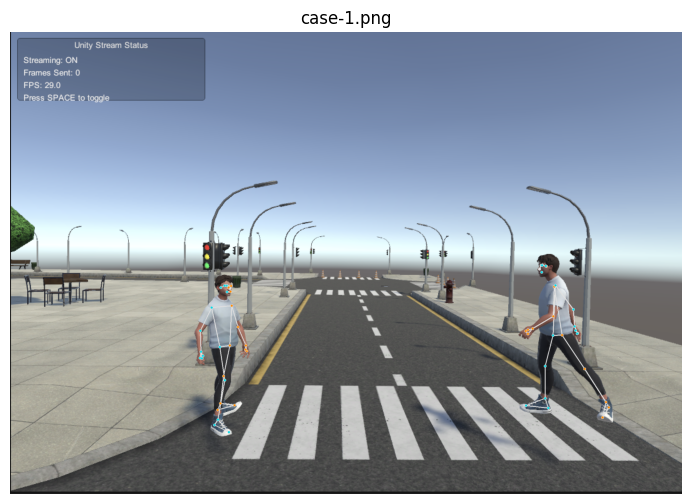

Processed case-3.png → pipeline_1/annotated_case-3.png


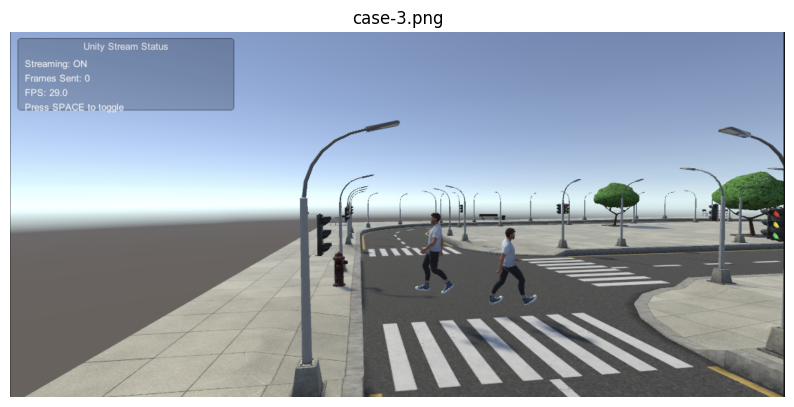

Processed case-2.png → pipeline_1/annotated_case-2.png


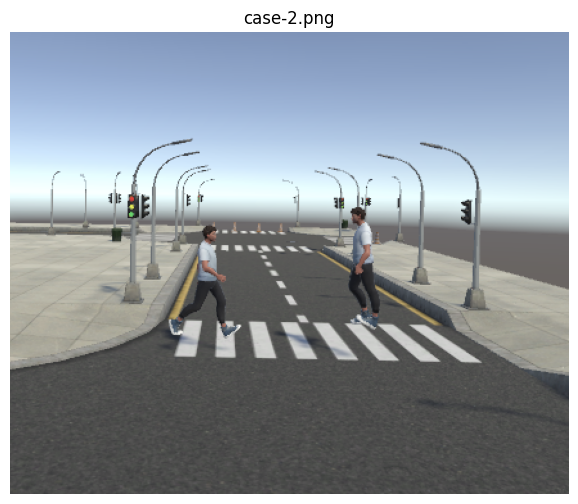

Processed case-6.png → pipeline_1/annotated_case-6.png


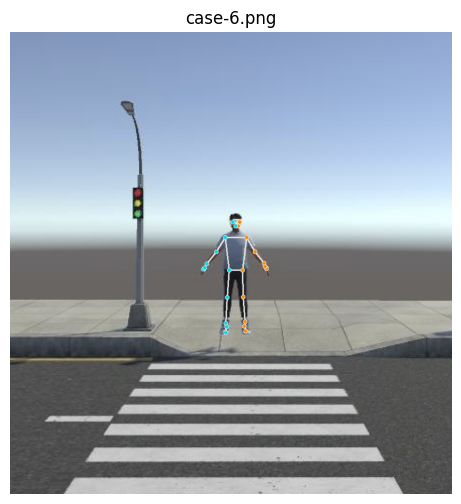

Processed case-5.png → pipeline_1/annotated_case-5.png


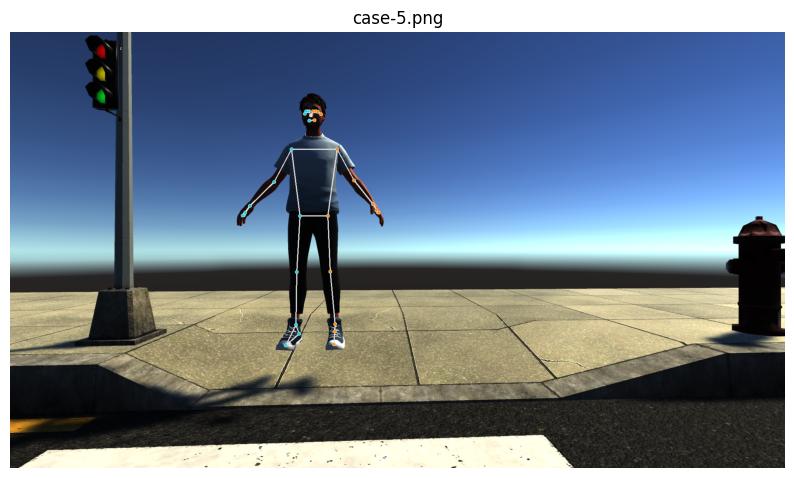

Processed case-4.png → pipeline_1/annotated_case-4.png


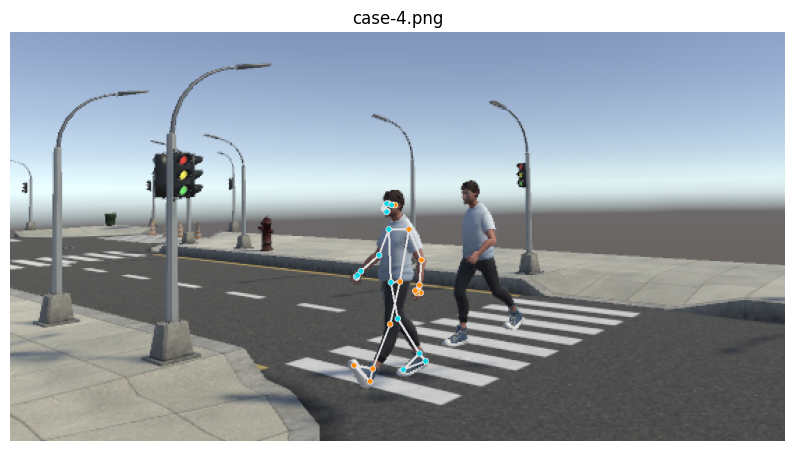

Done! All PNGs processed.


In [21]:
def draw_landmarks_on_image(rgb_image, detection_result):
  pose_landmarks_list = detection_result.pose_landmarks
  annotated_image = np.copy(rgb_image)

  # Loop through the detected poses to visualize.
  for idx in range(len(pose_landmarks_list)):
    pose_landmarks = pose_landmarks_list[idx]

    # Draw the pose landmarks.
    pose_landmarks_proto = landmark_pb2.NormalizedLandmarkList()
    pose_landmarks_proto.landmark.extend([
      landmark_pb2.NormalizedLandmark(x=landmark.x, y=landmark.y, z=landmark.z) for landmark in pose_landmarks
    ])
    solutions.drawing_utils.draw_landmarks(
      annotated_image,
      pose_landmarks_proto,
      solutions.pose.POSE_CONNECTIONS,
      solutions.drawing_styles.get_default_pose_landmarks_style())
  return annotated_image

base_options = python.BaseOptions(model_asset_path='pose_landmarker_heavy.task')
options = vision.PoseLandmarkerOptions(
    base_options=base_options,
    num_poses=2,
    output_segmentation_masks=True)
detector = vision.PoseLandmarker.create_from_options(options)


INPUT_FOLDER = "scenarios"
OUTPUT_FOLDER = "pipeline_1" 
os.makedirs(OUTPUT_FOLDER, exist_ok=True)

for filename in os.listdir(INPUT_FOLDER):
    if filename.lower().endswith(".png"):
        input_path = os.path.join(INPUT_FOLDER, filename)

        # Load image via Mediapipe
        mp_image = mp.Image.create_from_file(input_path)
        rgb_image = mp_image.numpy_view()

        # Run pose detection
        detection_result = detector.detect(mp_image)

        # Convert to BGR for OpenCV drawing
        bgr_image = cv2.cvtColor(rgb_image, cv2.COLOR_RGB2BGR)
        annotated_bgr = draw_landmarks_on_image(bgr_image, detection_result)

        # Save output image
        output_path = os.path.join(OUTPUT_FOLDER, f"annotated_{filename}")
        cv2.imwrite(output_path, annotated_bgr)

        print(f"Processed {filename} → {output_path}")

        display_img = cv2.cvtColor(annotated_bgr, cv2.COLOR_BGR2RGB)
        plt.figure(figsize=(10,6))
        plt.title(filename)
        plt.axis('off')
        plt.imshow(display_img)
        plt.show()

print("Done! All PNGs processed.")


### Pipeline2: Detection output -> Input to Pose estimation model

In [22]:
def visualize(
    image,
    detection_result
) -> np.ndarray:
  """Draws bounding boxes on the input image and return it.
  Args:
    image: The input RGB image.
    detection_result: The list of all "Detection" entities to be visualize.
  Returns:
    Image with bounding boxes.
  """
  for idx, detection in enumerate(detection_result.detections):

    # Draw label and score
    category = detection.categories[0]
    category_name = category.category_name
    if category_name == 'person':

        # Draw bounding_box
      bbox = detection.bounding_box
      start_point = bbox.origin_x, bbox.origin_y
      end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height

      cv2.rectangle(image, start_point, end_point, TEXT_COLOR, 3)

      probability = round(category.score, 2)
      result_text = category_name + ' (' + str(probability) + ')'
      text_location = (MARGIN + bbox.origin_x,
                      MARGIN + ROW_SIZE + bbox.origin_y)
      cv2.putText(image, result_text, text_location, cv2.FONT_HERSHEY_PLAIN,
                  FONT_SIZE, TEXT_COLOR, FONT_THICKNESS)

  return image

I0000 00:00:1764288443.549092 15984348 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1 Pro
W0000 00:00:1764288443.628029 16039032 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
W0000 00:00:1764288443.640451 16039035 inference_feedback_manager.cc:114] Feedback manager requires a model with a single signature inference. Disabling support for feedback tensors.
I0000 00:00:1764288443.650195 15984348 gl_context.cc:369] GL version: 2.1 (2.1 Metal - 90.5), renderer: Apple M1 Pro


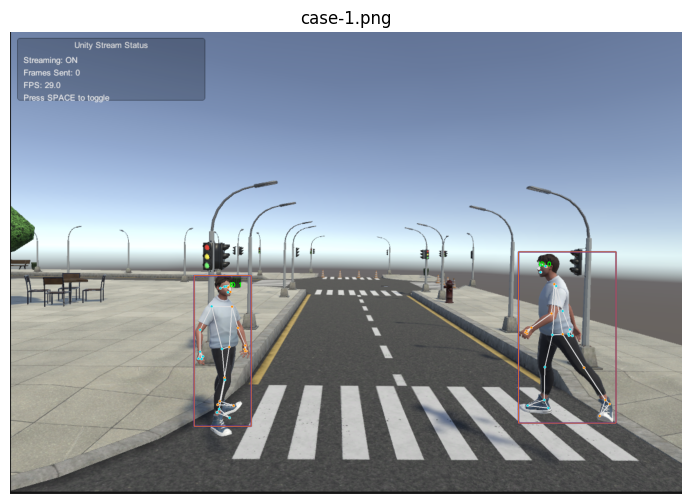

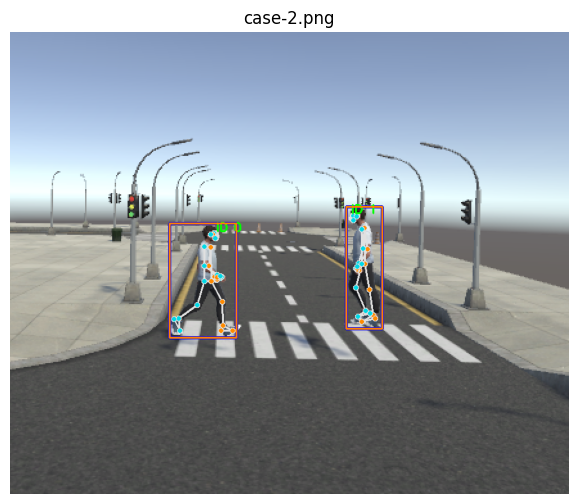

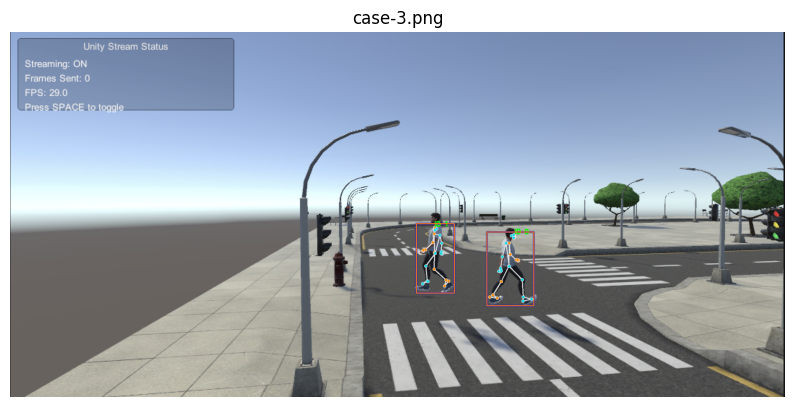

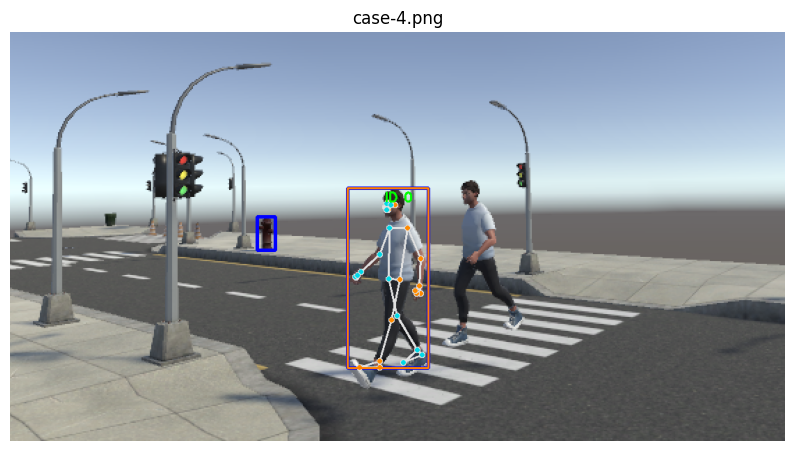

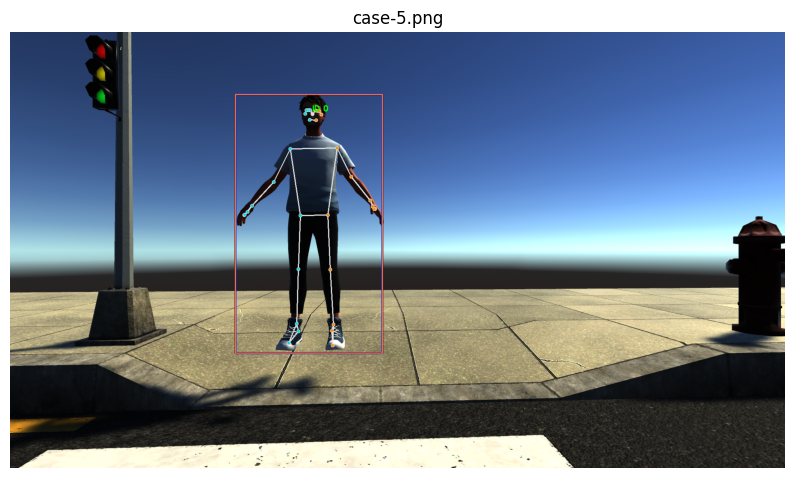

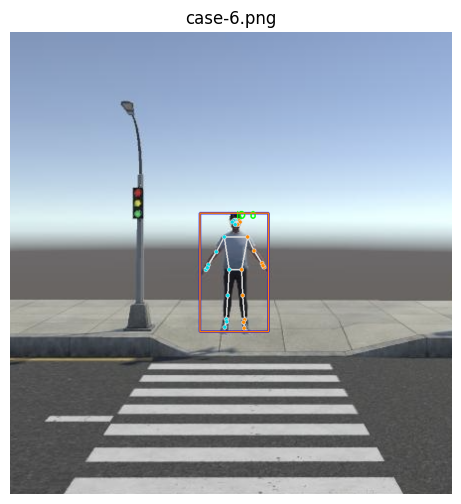

Done. Annotated images saved to: pipeline_2


In [23]:
INPUT_DIR = "scenarios"      # folder with .png images
OUTPUT_DIR = "pipeline_2"
TEXT_COLOR = (255, 0, 0)  # red
os.makedirs(OUTPUT_DIR, exist_ok=True)

SCORE_THRESHOLD = 0.4  # detection threshold for person

# === Helpers (same logic as your server) ===
def crop_from_bbox(image, bbox):
    x1 = int(bbox.origin_x)
    y1 = int(bbox.origin_y)
    x2 = int(bbox.origin_x + bbox.width)
    y2 = int(bbox.origin_y + bbox.height)

    H, W = image.shape[:2]
    x1 = max(0, min(W - 1, x1))
    y1 = max(0, min(H - 1, y1))
    x2 = max(0, min(W, x2))
    y2 = max(0, min(H, y2))

    if x2 <= x1 or y2 <= y1:
        return None
    return image[y1:y2, x1:x2]

def draw_landmarks_on_image(bgr_image, pose_landmarks_list, person_ids=None):
    annotated = bgr_image.copy()
    if not pose_landmarks_list:
        return annotated
    for idx, lm_list in enumerate(pose_landmarks_list):
        proto = landmark_pb2.NormalizedLandmarkList()
        proto.landmark.extend([landmark_pb2.NormalizedLandmark(x=lmk.x, y=lmk.y, z=lmk.z) for lmk in lm_list])
        mp.solutions.drawing_utils.draw_landmarks(
            annotated,
            proto,
            mp.solutions.pose.POSE_CONNECTIONS,
            mp.solutions.drawing_styles.get_default_pose_landmarks_style()
        )
        # optional id text
        if person_ids:
            nose = lm_list[0]
            px = int(nose.x * annotated.shape[1])
            py = int(nose.y * annotated.shape[0]) - 8
            cv2.putText(annotated, f"ID {person_ids[idx]}", (px, py),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0,255,0), 2)
    return annotated

pose_base = python.BaseOptions(model_asset_path='pose_landmarker_full.task')
pose_opts = vision.PoseLandmarkerOptions(base_options=pose_base, output_segmentation_masks=False, num_poses=1)
pose_detector = vision.PoseLandmarker.create_from_options(pose_opts)

det_base = python.BaseOptions(model_asset_path='efficientdet_lite2.tflite')
det_opts = vision.ObjectDetectorOptions(base_options=det_base, score_threshold=SCORE_THRESHOLD, max_results=2)
object_detector = vision.ObjectDetector.create_from_options(det_opts)

png_files = sorted([f for f in os.listdir(INPUT_DIR) if f.lower().endswith('.png')])
if len(png_files) == 0:
    raise SystemExit(f"No .png files found in {INPUT_DIR}")

for fn in png_files:
    path = os.path.join(INPUT_DIR, fn)
    # read with OpenCV (BGR)
    frame_bgr = cv2.imread(path, cv2.IMREAD_COLOR)
    if frame_bgr is None:
        print("Failed to read:", path)
        continue
    H_full, W_full = frame_bgr.shape[:2]

    # convert to RGB and create mp.Image
    frame_rgb = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
    mp_img = mp.Image(image_format=mp.ImageFormat.SRGB, data=frame_rgb)

    # Detect persons
    det_res = object_detector.detect(mp_img)
    
    pose_landmarks_global = []
    debug_bboxes = []

    if det_res and det_res.detections:
        for det in det_res.detections:
            if not det.categories:
                continue
            cat = det.categories[0].category_name
            score = det.categories[0].score or 0.0
            if cat != 'person' or score < SCORE_THRESHOLD:
                continue
            bbox = det.bounding_box
            start_point = bbox.origin_x, bbox.origin_y
            end_point = bbox.origin_x + bbox.width, bbox.origin_y + bbox.height

            cv2.rectangle(frame_bgr, start_point, end_point, TEXT_COLOR, 3)
            # crop person
            crop_bgr = crop_from_bbox(frame_bgr, bbox)
            if crop_bgr is None:
                continue
            crop_rgb = cv2.cvtColor(crop_bgr, cv2.COLOR_BGR2RGB)
            mp_crop = mp.Image(image_format=mp.ImageFormat.SRGB, data=crop_rgb)

            # pose on crop
            try:
                crop_pose = pose_detector.detect(mp_crop)
            except Exception as e:
                print("Pose detect failed on crop:", e)
                crop_pose = None

            if crop_pose and crop_pose.pose_landmarks:
                for pose_landmarks in crop_pose.pose_landmarks:
                    transformed = []
                    for lmk in pose_landmarks:
                        gx = (bbox.origin_x + (lmk.x * bbox.width)) / float(W_full)
                        gy = (bbox.origin_y + (lmk.y * bbox.height)) / float(H_full)
                        gz = float(lmk.z) if hasattr(lmk, 'z') else 0.0
                        transformed.append(landmark_pb2.NormalizedLandmark(x=gx, y=gy, z=gz))
                    pose_landmarks_global.append(transformed)
                    debug_bboxes.append((int(bbox.origin_x), int(bbox.origin_y),
                                         int(bbox.origin_x + bbox.width), int(bbox.origin_y + bbox.height)))

    # visualization
    annotated = draw_landmarks_on_image(frame_bgr, pose_landmarks_global, person_ids=list(range(len(pose_landmarks_global))))
    # draw debug boxes
    for (x1,y1,x2,y2) in debug_bboxes:
        cv2.rectangle(annotated, (x1,y1), (x2,y2), (0,128,255), 2)

    # Save annotated image
    out_path = os.path.join(OUTPUT_DIR, f"annot_{fn}")
    cv2.imwrite(out_path, annotated)

    # Display inline (convert BGR->RGB for matplotlib)
    display_img = cv2.cvtColor(annotated, cv2.COLOR_BGR2RGB)
    plt.figure(figsize=(10,6))
    plt.title(fn)
    plt.axis('off')
    plt.imshow(display_img)
    plt.show()

print("Done. Annotated images saved to:", OUTPUT_DIR)
